<a href="https://colab.research.google.com/github/inesbsilveira/hummingbirds/blob/main/wildfires_risk_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install geojson

In [2]:
import os
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, mapping
from shapely.validation import make_valid
import geojson
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
my_project = 'ee-ineshummingbirds'
ee.Authenticate()
ee.Initialize(project= my_project)

In [4]:
# Create a function to process burned area by year
def process_year(n):
    # Calculate the start and end date for each year
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    # Filter the burned area collection for the given year
    result = sst.filterDate(ini, end)
    result = result.max().set('system:time_start', ini)

    # Get the burned area (where BurnDate is not 0) and mask it
    result = ee.Image.pixelArea() \
               .divide(10000) \
               .updateMask(result.neq(0))  # Mask out non-burned areas

    # Sum the area of burned forest for the year
    result = result.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=File,  # Use the converted region geometry
        scale=500,
        maxPixels=1e12,
        tileScale=4
    )

    # Extract the area burned in the forest for that year
    burnedArea = result.get('area')

    # Return the area burned in the forest for that year
    return ee.Feature(None, {'burned_area_ha': burnedArea})

def get_shapefile_centroid(gdf):
    """Ensure CRS is geographic and return the centroid coordinates."""
    if gdf.crs is None or gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    centroid = gdf.unary_union.centroid
    return centroid.y, centroid.x  # (latitude, longitude)

def get_best_crs(latitude, longitude):
    """ Returns the best UTM zone EPSG code based on latitude """
    utm_zone = int((180 + longitude) / 6) + 1
    return f"EPSG:{32600 + utm_zone if latitude >= 0 else 32700 + utm_zone}"

In [36]:

# if the input is a shapefile
country = 'Ivory Coast'
project_area_name = 'Calao' #region/country/project name
input_shp = "cambodia_shp_joined_dissolved.shp"
gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')
File = geemap.geopandas_to_ee(gdf)

In [37]:
# Define the date range
start_date = '2000-01-01'
end_date = '2024-12-31'
startDate = ee.Date(start_date)
endDate = ee.Date(end_date)

In [38]:
# calculate number of years to process
nYears = ee.Number(endDate.difference(startDate, 'year')).round().subtract(1)
#print(f'Number of years: {nYears.getInfo()}')

# MODIS Burned Area dataset
sst = ee.ImageCollection("MODIS/061/MCD64A1") \
            .select('BurnDate') \
            .filterDate(startDate, endDate)

# processs burned area per year
byYear = ee.FeatureCollection(
    ee.List.sequence(0, nYears).map(process_year)
)

In [39]:
#features from the Earth Engine FeatureCollection
features = byYear.getInfo()['features']

#'area_ha' values and their corresponding years
data = []
for feature in features:
    year = feature['id']  # The id corresponds to the year index (0-9 in your case)
    area_ha = feature['properties']['burned_area_ha']
    data.append({'year': int(year), 'burned_area_ha': area_ha})

#convert to pandas dataframe
df = pd.DataFrame(data)
# Display the DataFrame
#print(df)


In [40]:
#retrive lat and long to get the adequate CRS for a correct area calculation
latitude, longitude = get_shapefile_centroid(gdf)
#print(f"Central Point: ({latitude}, {longitude})")
best_epsg = get_best_crs(latitude, longitude)
#print(best_epsg)

<ipython-input-4-b14001e8e1ae>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid


In [41]:
gdf_crs = gdf.to_crs(best_epsg)
total_area_ha = (gdf_crs['geometry'].area/10000).sum()
print(f"Total area in hectares: {total_area_ha}")

Total area in hectares: 16063.192346372653


In [42]:
#add new column to the df with the percentage of burned area per year
df['burned_area_percentage'] = (df['burned_area_ha'] / total_area_ha) * 100
# Display the updated DataFrame
print(df)

    year  burned_area_ha  burned_area_percentage
0      0      482.573603                3.004220
1      1      733.900220                4.568832
2      2     5219.064837               32.490832
3      3     4439.816291               27.639688
4      4     4337.539252               27.002972
5      5     3664.798666               22.814884
6      6     4512.663041               28.093189
7      7     6036.517969               37.579815
8      8     6973.930456               43.415595
9      9     6857.176544               42.688753
10    10     6453.893551               40.178150
11    11     5434.327963               33.830934
12    12     5550.852045               34.556344
13    13     4123.897533               25.672964
14    14     5499.687089               34.237821
15    15     3759.299711               23.403192
16    16     4036.988500               25.131919
17    17     4706.492033               29.299855
18    18     5898.895369               36.723058
19    19     5716.97

In [43]:
# Calculate mean and standard deviation for area burned in hectares
mean_area = df['burned_area_ha'].mean()
std_area = df['burned_area_ha'].std()
mean_area_percentage = df['burned_area_percentage'].mean()
std_area_percentage = df['burned_area_percentage'].std()
print(f"Mean of burned area (ha): {mean_area}")
print(f"Standard deviation of burned area: {std_area}")
print(f"Mean of burned area (%): {mean_area_percentage}")
print(f"Standard deviation of burned area (%): {std_area_percentage}")

Mean of burned area (ha): 4978.342075852695
Standard deviation of burned area: 1838.8851551642447
Mean of burned area (%): 30.992233477032922
Standard deviation of burned area (%): 11.447818811554583


In [44]:
#TIME SINCE LAST FIRE
# Sort data by year (ensure it's sorted)
df = df.sort_values('year', ascending=True)
big_fire_threshold_area = mean_area
low_fire_threshold_area = mean_area - (std_area)

# Find the most recent year with a big fire
big_fires = df[df['burned_area_ha'] >= big_fire_threshold_area]
num_big_fires = len(big_fires)

moderate_fires = df[(df['burned_area_ha'] >= low_fire_threshold_area) & (df['burned_area_ha'] < big_fire_threshold_area)]
num_moderate_fires = len(moderate_fires)

low_fires = df[df['burned_area_ha'] < low_fire_threshold_area]
num_low_fires = len(low_fires)

if not big_fires.empty:
    last_big_fire_year = big_fires['year'].max()
else:
    last_big_fire_year = None  # No big fire found

# current year is the most recent year in the dataset (ascending order)
current_year = df['year'].max()

# calculate time since last (big)fire
if last_big_fire_year:
    years_since_last_big_fire = current_year - last_big_fire_year
else:
    years_since_last_big_fire = float('inf')  # If no fire, treat as very long ago



print(f"Total number of big fires: {num_big_fires}")
print(f"Total number of moderate fires: {num_moderate_fires}")
print(f"Total number of low fires: {num_low_fires}")
print(f"Year of last big fire: 20{last_big_fire_year}")
print(f"Nr of years since last big fire: {years_since_last_big_fire}")


Total number of big fires: 14
Total number of moderate fires: 8
Total number of low fires: 3
Year of last big fire: 2024
Nr of years since last big fire: 0


In [45]:
# Filter moderate and low fires that happened after the last big fire
# Filter fires that happened after the last big fire
if last_big_fire_year:
    fires_after_last_big_fire = df[df['year'] > last_big_fire_year]

    moderate_fires_after = fires_after_last_big_fire[
        (fires_after_last_big_fire['burned_area_ha'] >= low_fire_threshold_area) &
        (fires_after_last_big_fire['burned_area_ha'] < big_fire_threshold_area)
    ]

    low_fires_after = fires_after_last_big_fire[
        fires_after_last_big_fire['burned_area_ha'] < low_fire_threshold_area
    ]

    total_fires_after_last_big_fire = len(fires_after_last_big_fire)
else:
    moderate_fires_after = df[(df['burned_area_ha'] >= low_fire_threshold_area) &
                              (df['burned_area_ha'] < big_fire_threshold_area)]
    low_fires_after = df[df['burned_area_ha'] < low_fire_threshold_area]
    total_fires_after_last_big_fire = len(df)  # Count all fires if no big fire exists


# Count fires
num_moderate_fires_after = len(moderate_fires_after)
num_low_fires_after = len(low_fires_after)

print(f"Total number of fires after last big fire: {total_fires_after_last_big_fire}")
print(f"Total number of moderate fires after last big fire: {num_moderate_fires_after}")
print(f"Total number of low fires after last big fire: {num_low_fires_after}")

Total number of fires after last big fire: 0
Total number of moderate fires after last big fire: 0
Total number of low fires after last big fire: 0


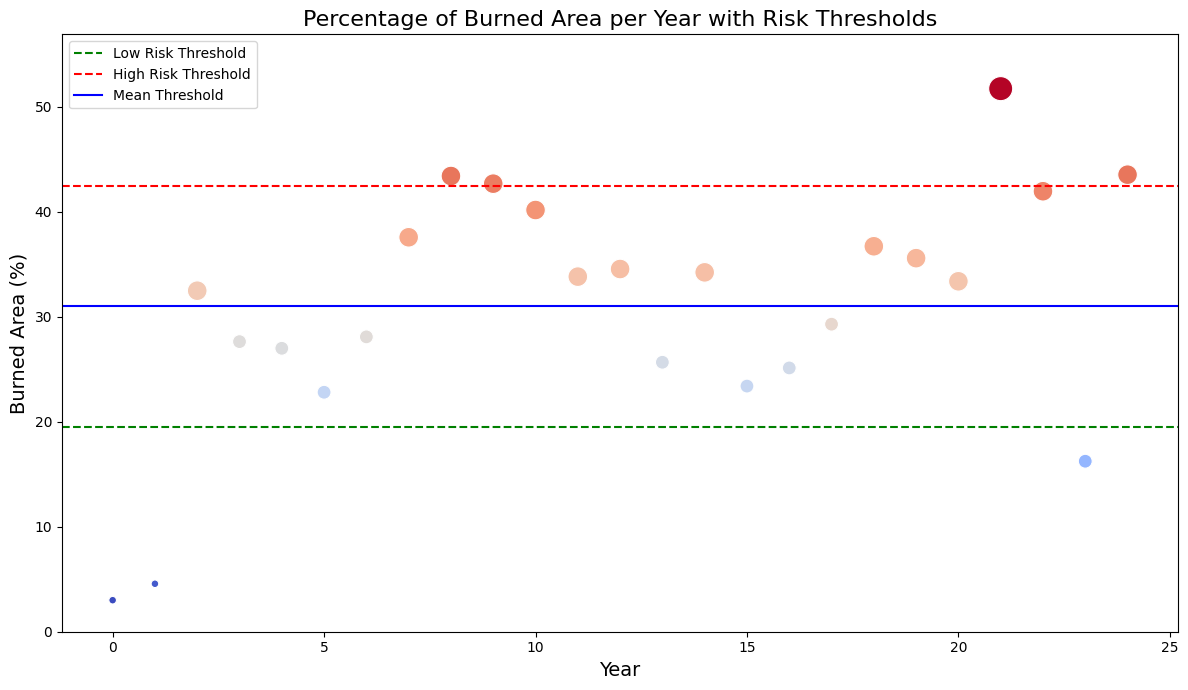

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate thresholds for risk levels
mean_area = df['burned_area_percentage'].mean()
std_area = df['burned_area_percentage'].std()

low_risk_threshold = mean_area - (std_area)
high_risk_threshold = mean_area + (std_area)
mean_threshold = mean_area
# Categorize the point sizes based on the area burned
def size_category(burned_area_percentage):
    if burned_area_percentage < 10:
        return 30  # Small
    elif 10 <= burned_area_percentage < 30:
        return 100  # Medium
    elif 30 <= burned_area_percentage < 50:
        return 200  # Medium-large
    else:
        return 300  # Large

# Apply the size category function to the 'burned_area_ha' column
df['point_size'] = df['burned_area_percentage'].apply(size_category)

# Create the scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='year', y='burned_area_percentage', size='point_size', sizes=(30, 300),
                hue='burned_area_percentage', palette='coolwarm', legend=False)

# Add horizontal lines for risk thresholds
plt.axhline(y=low_risk_threshold, color='green', linestyle='--', label='Low Risk Threshold')
plt.axhline(y=high_risk_threshold, color='red', linestyle='--', label='High Risk Threshold')
plt.axhline(y=mean_threshold, color='blue', linestyle='-', label='Mean Threshold')

# Set labels and title
plt.title('Percentage of Burned Area per Year with Risk Thresholds', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Burned Area (%)', fontsize=14)
#plt.yscale('log')
plt.ylim(0, df['burned_area_percentage'].max()*1.1)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
